In [1]:
import pandas as pd
import tensorflow
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2

In [2]:
base_model=MobileNetV2 (include_top=False, weights="imagenet",input_shape= (224,224,3))

In [3]:
model = Sequential ()
model.add (base_model)
model.add (Conv2D(64, (3, 3), activation = 'relu'))
model.add (MaxPooling2D (pool_size = (2, 2)))
model.add (Dropout (0.40))
model.add (Flatten ())
model.add (Dense (128,activation='relu'))
model.add (Dropout (0.4))
model.add (Dense (7, activation='sigmoid'))

In [4]:
data=pd.read_csv("F:/PROJECT/Dataset/HAM10000/HAM10000_metadata.csv")
data['image_name']=data['image_id']+'.jpg'
X=data[['image_name', 'dx','lesion_id']]

In [5]:
X.sample(5)

,image_name,dx,lesion_id
8992,ISIC_0030603.jpg,nv,HAM_0006921
5444,ISIC_0027396.jpg,nv,HAM_0001491
9206,ISIC_0029792.jpg,nv,HAM_0005250
7582,ISIC_0032512.jpg,nv,HAM_0003735
1587,ISIC_0033485.jpg,mel,HAM_0003556


In [6]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test=train_test_split (X,Y,test_size=0.17, random_state=42)
X_train,X_val,y_train,y_val=train_test_split(X_train, y_train, test_size=0.17, random_state=42)

In [7]:
train=pd.concat ([X_train,y_train],axis=1)
val=pd.concat ([X_val,y_val],axis=1)
test=pd.concat ([X_test,y_test],axis=1)

In [8]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder ()
encoder.fit (val['dx'])
name_as_indexes_train=encoder.transform(val['dx'])
val['label']=name_as_indexes_train

In [9]:
encoder=LabelEncoder ()
encoder.fit (test['dx'])
name_as_indexes_test=encoder.transform(test['dx'])
test ['label']=name_as_indexes_test

In [10]:
from keras_preprocessing.image import ImageDataGenerator

In [11]:

train_generator = ImageDataGenerator (rescale = 1./255,
                                    rotation_range=10,
                                    zoom_range = 0.1,
                                    width_shift_range=0.0,
                                    height_shift_range=0.00)

In [12]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_name",y_col="dx",
                                                batch_size=32, directory="F:\PROJECT\Dataset\HAM10000\DATA",
                                                shuffle=True, class_mode="categorical",target_size=(224,224))

Found 6898 validated image filenames belonging to 7 classes.


In [13]:
test_generator=ImageDataGenerator(rescale = 1./255,
                                  rotation_range=10,
                                  zoom_range = 0.1,
                                  width_shift_range=0.0, 
                                  height_shift_range=0.02)

In [14]:
test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_name",y_col="dx",
                                                directory="F:\PROJECT\Dataset\HAM10000\DATA",
                                                shuffle=False, batch_size=1, class_mode=None, target_size= (224, 224))

Found 1703 validated image filenames.


In [15]:
val_data=test_generator.flow_from_dataframe (dataframe=val,x_col="image_name",y_col="dx",
                                            directory="F:\PROJECT\Dataset\HAM10000\DATA",
                                            batch_size=64, shuffle=False, class_mode="categorical",target_size=(224,224))

Found 1414 validated image filenames belonging to 7 classes.


In [16]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau (monitor='val_acc',patience=3, verbose=1, factor=.5, min_lr=0.0001)


In [17]:
from keras.optimizers import Adam,SGD
sgd = optimizers.SGD(learning_rate= 0.01, clipvalue = 0.5)
model.compile (optimizer=sgd, loss="categorical_crossentropy",metrics=["accuracy"])

In [18]:
history = model.fit(train_data,
                    steps_per_epoch=train_data.samples//train_data.batch_size,
                    validation_data=val_data,
                    verbose=1,
                    validation_steps=val_data.samples//val_data.batch_size,
                    epochs=50,
                    callbacks=[learning_control])


Epoch 1/50
215/215 [==============================] - 1240s 5s/step - loss: 1.0876 - accuracy: 0.6557 - val_loss: 1.3473 - val_accuracy: 0.6733 - lr: 0.0100
Epoch 2/50
215/215 [==============================] - 880s 4s/step - loss: 0.8241 - accuracy: 0.7020 - val_loss: 2.7400 - val_accuracy: 0.6733 - lr: 0.0100
Epoch 3/50
215/215 [==============================] - 883s 4s/step - loss: 0.7449 - accuracy: 0.7319 - val_loss: 3.0470 - val_accuracy: 0.6733 - lr: 0.0100
Epoch 4/50
215/215 [==============================] - 924s 4s/step - loss: 0.6837 - accuracy: 0.7544 - val_loss: 1.3983 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 5/50
215/215 [==============================] - 876s 4s/step - loss: 0.6115 - accuracy: 0.7775 - val_loss: 1.5578 - val_accuracy: 0.6776 - lr: 0.0100
Epoch 6/50
215/215 [==============================] - 853s 4s/step - loss: 0.5490 - accuracy: 0.8032 - val_loss: 1.3134 - val_accuracy: 0.6768 - lr: 0.0100
Epoch 7/50
215/215 [==============================] - 831s 4s/s

In [19]:
model.save ('model98.h5')

In [20]:
import matplotlib.pyplot as plt

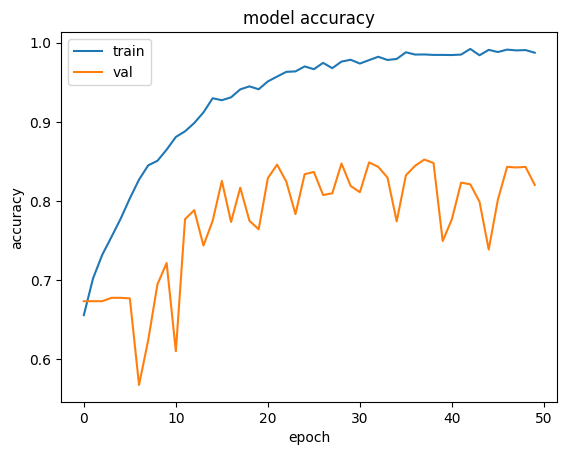

In [21]:
plt.plot (history.history['accuracy'])
plt.plot (history.history['val_accuracy'])
plt.title ('model accuracy')
plt.ylabel ('accuracy')
plt.xlabel ('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


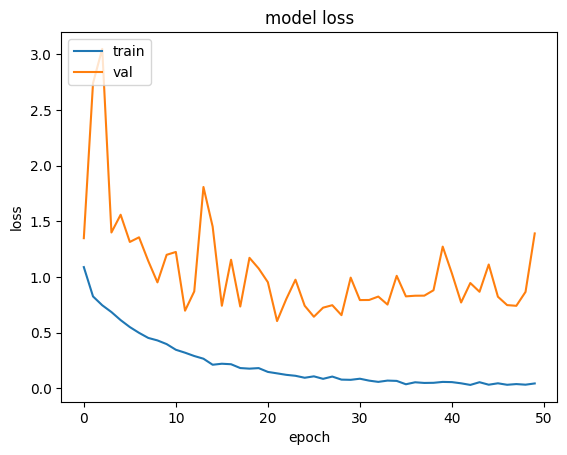

In [22]:
plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])
plt.title('model loss')
plt.ylabel("loss")
plt.xlabel ('epoch')
plt.legend (['train', 'val'], loc='upper left')
plt.show()

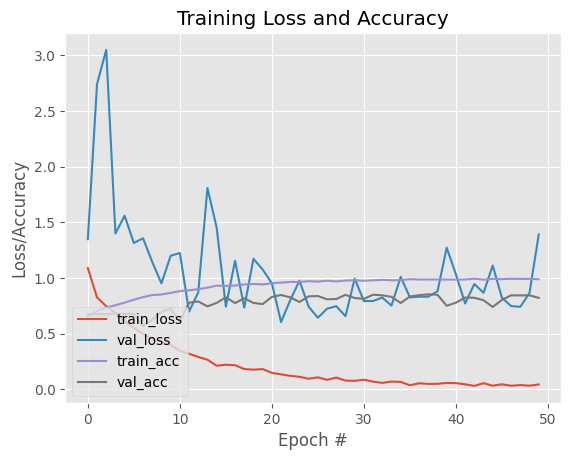

In [24]:
N=50
plt.style.use ("ggplot")
plt.figure()
plt.plot (np.arange (0, N), history.history["loss"], label="train_loss")
plt.plot (np.arange (0, N), history.history["val_loss"], label="val_loss")
plt.plot (np.arange (0, N), history.history["accuracy"], label="train_acc")
plt.plot (np.arange (0, N), history.history["val_accuracy"], label="val_acc")
plt.title ("Training Loss and Accuracy")
plt.xlabel ("Epoch #")
plt.ylabel ("Loss/Accuracy")
plt.legend (loc="lower left")


In [25]:
test_data.reset ()
predictions = model.predict(test_data, steps=test_data.samples/test_data.batch_size, verbose=1)
y_pred= np.argmax (predictions, axis=1)

1703/1703 [==============================] - 189s 106ms/step


In [26]:
c=np.where(y_pred == name_as_indexes_test)


In [27]:
np.count_nonzero(c)

1264

In [28]:
print ("Test Accuracy :",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy : 74.22196124486202


In [29]:
from sklearn.metrics import classification_report

In [30]:
#Generate a classification report
report = classification_report (name_as_indexes_test, y_pred)
print (report)

              precision    recall  f1-score   support

           0       0.51      0.53      0.52        62
           1       0.74      0.81      0.77        77
           2       0.76      0.43      0.55       201
           3       0.39      0.58      0.47        24
           4       0.30      0.24      0.26       191
           5       0.82      0.89      0.85      1128
           6       0.70      0.95      0.81        20

    accuracy                           0.74      1703
   macro avg       0.60      0.63      0.60      1703
weighted avg       0.73      0.74      0.73      1703



In [31]:
model.save ("model99.h5")

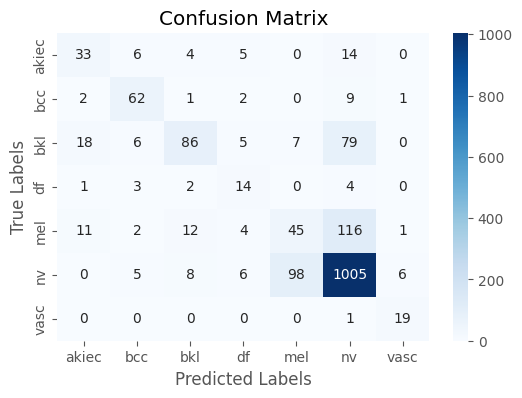

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
confusion = confusion_matrix(name_as_indexes_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
